# AP5 - Pattern Recognition
Train a Support Vector Machine (SVM) classifier to recognize 'Abrir', 'Fecahr' and 'Ligar' voice commands.

> Name: Jonas Carvalho Fortes

> Mat: 494513

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from IPython.display import Audio, display

## Auxiliary Functions

In [33]:
def get_audio_signal_from_dataset(df, index):
    """
    Retrieves an audio signal and its class label from a DataFrame containing an audio dataset.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the audio dataset.
        index (int): The index of the audio signal to retrieve.
        
    Returns:
        np.ndarray: The audio signal as a numpy array.
        label (int): The class label for the audio signal.
    """
    signal = df.iloc[index, :-1].values
    label = df.iloc[index, -1]
    return signal, label

In [34]:
def plot_audio_signal(signal, title="Audio Signal"):
    """
    Plots the audio signal as a waveform.
    
    Parameters:
        signal (np.ndarray): The audio signal as a numpy array.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Signal Value")
    plt.show()

In [35]:
def play_audio_signal(signal, sample_rate=44100*2.1):
    """
    Plays an audio signal using IPython's Audio display.
    
    Parameters:
        signal (np.ndarray): The audio signal as a numpy array.
        sample_rate (int): The sample rate of the audio signal in Hz. Default is 95900.
    """
    # Normalize the signal to the range [-1, 1] if it's in 16-bit PCM format
    if signal.dtype == np.int16:
        signal = signal / np.iinfo(np.int16).max  # Normalize to the range [-1, 1]
    
    # Display the audio player with the normalized signal
    display(Audio(signal, rate=sample_rate))

In [36]:
def extract_features(audio_signal, sample_rate):
    """
    Extract audio features using scipy.
    
    Parameters:
        audio_signal (np.array): The input audio signal.
        sample_rate (int): The sample rate of the audio signal.
        
    Returns:
        list: A list containing the extracted features for a single audio sample.
    """
    # Ensure the audio signal is of type float32
    audio_signal = audio_signal.astype(np.float32)
    
    # 1. Zero-Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio_signal))

    # 2. Root Mean Square (RMS) Energy
    rms_energy = np.mean(librosa.feature.rms(y=audio_signal))

    # 3. Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = np.mean(librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13), axis=1)

    # 4. Chroma
    chroma = np.mean(librosa.feature.chroma_stft(y=audio_signal, sr=sample_rate), axis=1)

    # 5. Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio_signal, sr=sample_rate), axis=1)

    # Combine all features into a list
    features = np.concatenate(([zcr, rms_energy], mfccs, chroma, spectral_contrast))

    return features

In [37]:
def extract_features_from_dataset(df, sample_rate):
    """
    Extract features from a DataFrame containing audio signals.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the audio signals.
        sample_rate (int): Sample rate of the audio signals.
    
    Returns:
        list: A list of dictionaries containing the extracted features for each signal.
    """
    features_list = []
    
    # Iterate over each row in the DataFrame and extract features
    for _, row in df.iterrows():
        signal = row[:-1].values
        features = extract_features(signal, sample_rate)
        features_list.append(features)
    
    return features_list

In [38]:
def plot_pca(X_pca, y):
    """
    Plots the PCA-reduced data with each class in a different color.
    
    Parameters:
        X_pca (np.ndarray): The PCA-reduced data.
        y (np.ndarray): The class labels.
    """
    
    plt.figure(figsize=(8,6))
    
    # Get unique class labels
    unique_classes = np.unique(y)
    
    for class_label in unique_classes:
        indices = np.where(y == class_label)
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Classe {class_label}', alpha=0.7)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Audio Features')
    plt.legend()
    plt.show()

## Feature extraction

### Load Dataset

In [9]:
# Path to the CSV file containing the audio dataset
file_path = "data/audio_signals_dataset.csv"

# Read the dataset from the CSV file
df = pd.read_csv(file_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,68611,68612,68613,68614,68615,68616,68617,68618,68619,label
0,43,239,41,228,26,225,57,228,70,231,...,-737,867,-701,977,-699,973,-713,923,-663,0
1,78,225,85,230,122,241,101,237,91,241,...,-577,287,-559,256,-542,247,-529,306,-523,0
2,98,208,115,212,97,214,95,211,101,217,...,-439,1423,-485,1547,-536,1643,-558,1786,-578,0
3,-11,172,11,174,24,183,37,190,80,193,...,-4866,-4673,-4823,-4700,-4833,-4799,-4742,-4548,-4517,0
4,15,222,36,221,48,239,107,242,139,242,...,-660,-490,-662,-474,-684,-411,-720,-361,-746,0


### Plotting the audio signals

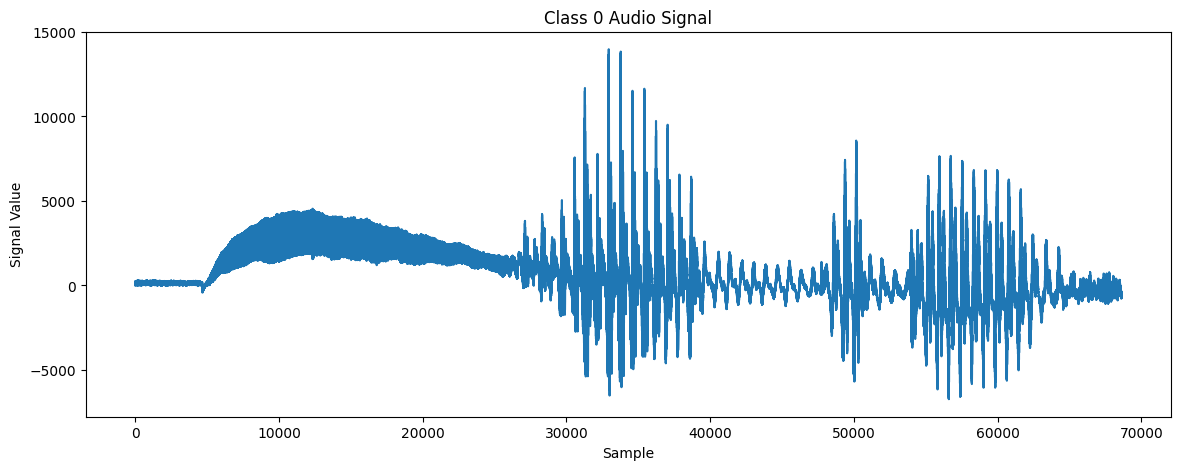

In [39]:
# Plot a sample audio signal from the dataset - class 0

audio_index = 4 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plot the audio signal
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

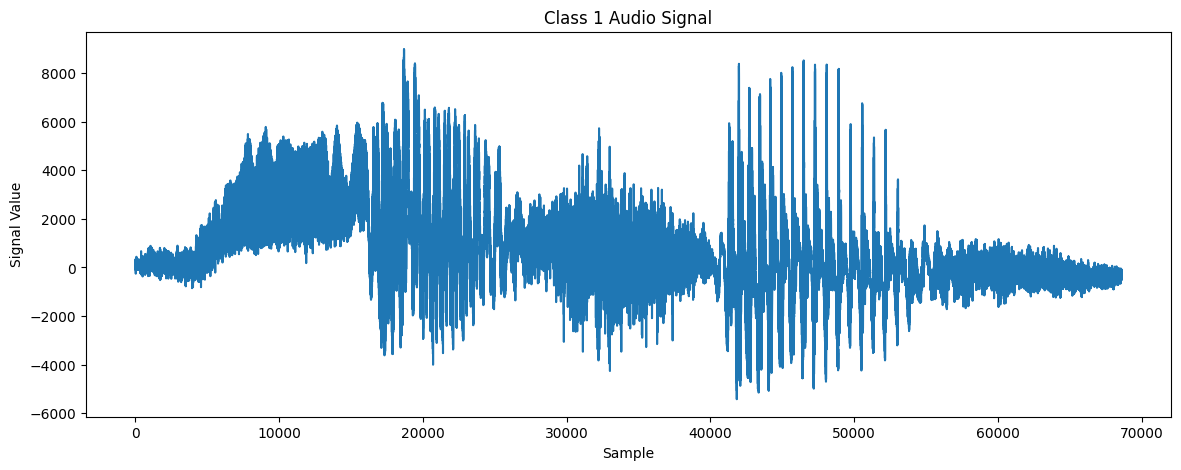

In [40]:
# Plot a sample audio signal from the dataset - class 1

audio_index = 15 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plot the audio signal
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

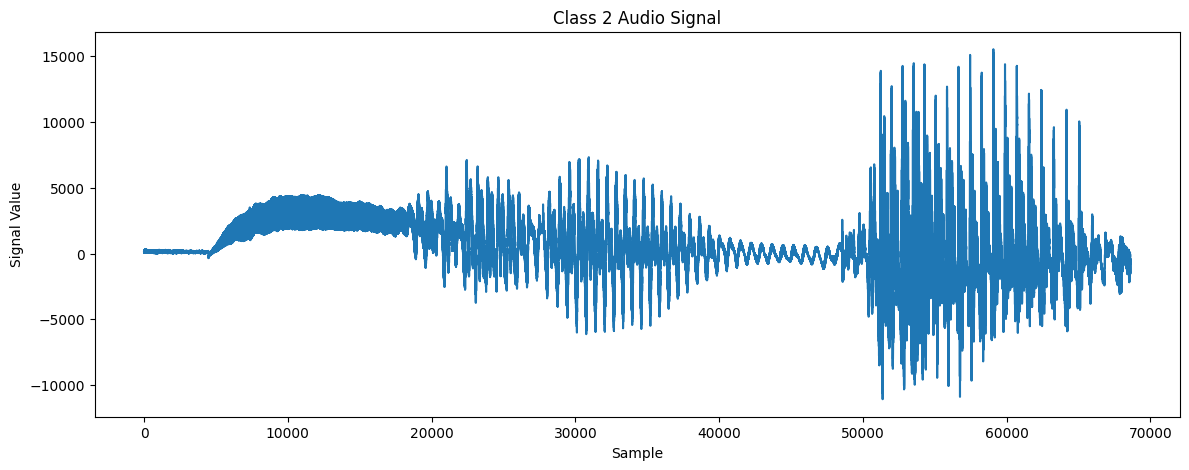

In [41]:
# Plot a sample audio signal from the dataset - class 2

audio_index = 30 
signal, class_label = get_audio_signal_from_dataset(df, audio_index)

# Plot the audio signal
plot_audio_signal(signal, title=f"Class {class_label} Audio Signal")

# Play the audio signal
play_audio_signal(signal)

### Feature extraction and PCA

In [52]:
# Extract features from the dataset
X = extract_features_from_dataset(df, sample_rate=44100*2.1)
y = df['label'].values



In [53]:
# 1. Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
# 2. Apply PCA
pca = PCA(n_components=2)  # Reduzindo para 2 componentes principais
X_pca = pca.fit_transform(X_scaled)

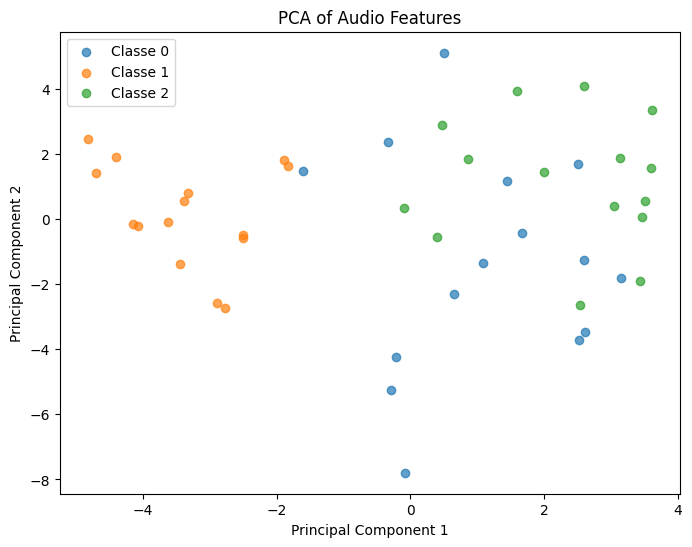

In [55]:
# Plot the PCA-reduced data
plot_pca(X_pca, y)

## Training the SVM 

In [22]:
# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Inicializa e treina o classificador SVM
svm_classifier = SVC(kernel='linear')  # Pode testar outros kernels como 'rbf'
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [24]:
# Avalia o desempenho
accuracy = svm_classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7777777777777778


In [25]:
# Previsões
y_pred = svm_classifier.predict(X_test)

print(f"Predictions: {y_pred}")
print(f"True labels: {y_test}")

Predictions: [2 1 1 2 1 2 0 0 2]
True labels: [2 1 1 2 2 2 0 0 0]
